#### Research Project "Towards a livability score: network-based urban analysis using OpenStreetMap data"

Imports

In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from pyrosm import OSM, get_data

import geopandas as gpd
from geopandas.tools import sjoin

from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import polygonize, linemerge

import networkx as nx

import pandas as pd

import numpy as np

from src import network_distance as nd
from src.network_distance import ge, _ge_Q, variance, _resistance, calculate_spl

##### Initialization

In [2]:
# Download data for the city of Copenhagen
fp = get_data("Copenhagen", directory="data/raw", update=False)

In [3]:
# Initialize the OSM object 
osm = OSM(fp)

Extracting Copenhagen administrative boundaries and using it as bouding box

In [4]:
# Retrieve all administrative boundaries for further inspection
boundaries = osm.get_boundaries()
print(boundaries[["name", "admin_level"]])

                      name admin_level
0          Region Sjælland           4
1       Region Hovedstaden           4
2            Greve Kommune           7
3           Solrød Kommune           7
4         Roskilde Kommune           7
5         Gentofte Kommune           7
6   Lyngby-Taarbæk Kommune           7
7         Gladsaxe Kommune           7
8    Frederiksberg Kommune           7
9            Ishøj Kommune           7
10      Vallensbæk Kommune           7
11   Høje-Taastrup Kommune           7
12     Albertslund Kommune           7
13        Glostrup Kommune           7
14         Allerød Kommune           7
15          Herlev Kommune           7
16         Rødovre Kommune           7
17          Egedal Kommune           7
18        Ballerup Kommune           7
19          Furesø Kommune           7
20       Rudersdal Kommune           7
21         Brøndby Kommune           7
22        Hvidovre Kommune           7
23          Dragør Kommune           7
24          Tårnby Kommun

In [5]:
# Get administrative boundary of Copenhagen (as bounding box)
bounding_box = osm.get_boundaries(name="Københavns Kommune")

In [6]:
bounding_box.head()

,name,ref,website,admin_level,boundary,id,timestamp,version,changeset,geometry,tags,osm_type
0,Københavns Kommune,101,None,7,administrative,1102142383,0,0,0,"MULTIPOLYGON (((12.45304 55.71225, 12.45309 55...","{""alt_name:gl"":""Concello de Copenhague"",""name:...",relation


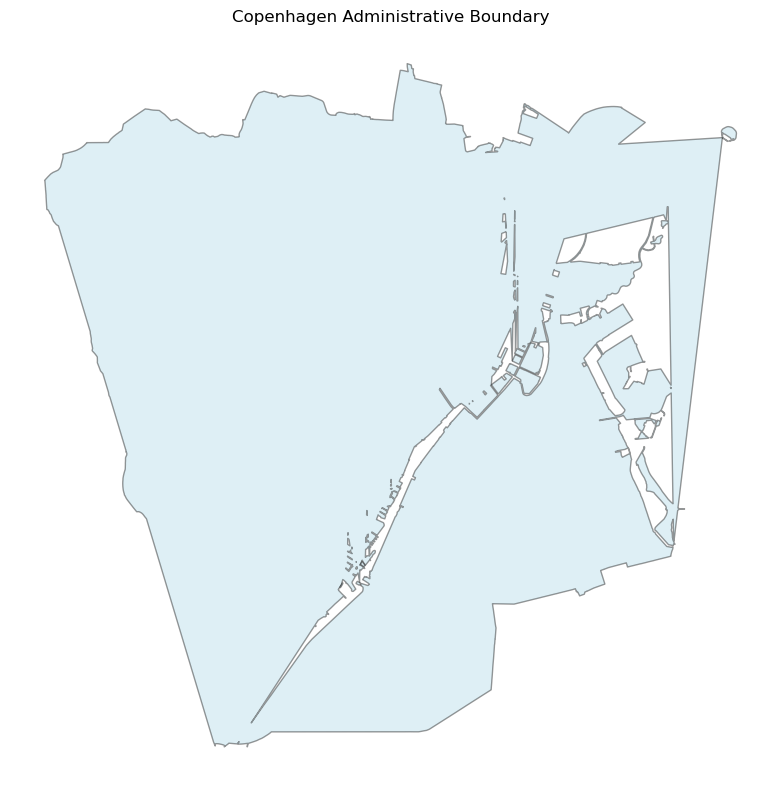

In [7]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot city boundary
bounding_box.plot(
    ax=ax,
    facecolor='lightblue',
    edgecolor='black',
    linewidth=1,
    alpha=0.4
)

# Add Title
ax.set_title("Copenhagen Administrative Boundary")
ax.axis("off")
plt.tight_layout()

# # Save figure and close it
# plt.savefig("1.Copenhagen administrative boundary.png", dpi=300, bbox_inches="tight")
# plt.close()

In [8]:
from shapely.geometry import Polygon, MultiPolygon

# Get the administrative boundary for Copenhagen
bounding_box = osm.get_boundaries(name="Københavns Kommune")

# Function to drop holes
def drop_holes(geom):
    if geom.geom_type == "Polygon":
        return Polygon(geom.exterior)  # keep only outer shell
    elif geom.geom_type == "MultiPolygon":
        return MultiPolygon([Polygon(p.exterior) for p in geom.geoms])
    else:
        return geom

# Apply to your GeoDataFrame
bounding_box["geometry"] = bounding_box["geometry"].apply(drop_holes)

In [9]:
# Keep only the largest polygon
bounding_box["geometry"] = bounding_box["geometry"].apply(
    lambda g: max(g.geoms, key=lambda p: p.area) if g.geom_type == "MultiPolygon" else g
)

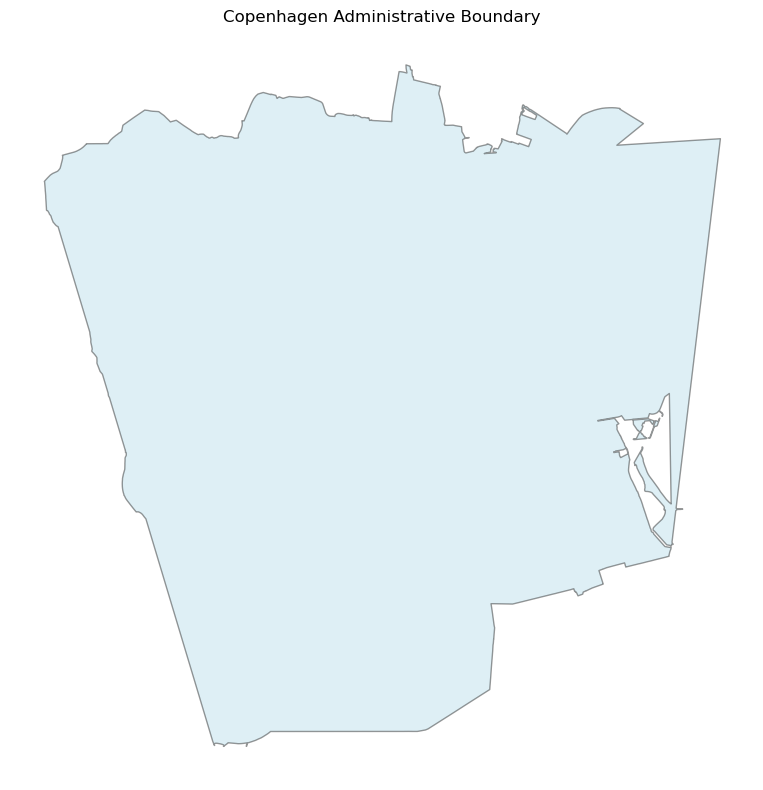

In [10]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot city boundary
bounding_box.plot(
    ax=ax,
    facecolor='lightblue',
    edgecolor='black',
    linewidth=1,
    alpha=0.4
)

# Add Title
ax.set_title("Copenhagen Administrative Boundary")
ax.axis("off")
plt.tight_layout()

# # Save figure and close it
# plt.savefig("1.Copenhagen administrative boundary.png", dpi=300, bbox_inches="tight")
# plt.close()

In [11]:
# Get the shapely geometry from GeoDataFrame
bbox_geom = bounding_box['geometry'].values[0]

# Initiliaze OSM with bounding box
osm = OSM(fp, bounding_box=bbox_geom)

Extracting all the necessary data

In [12]:
# Extract all driving roads
driving_roads = osm.get_network(network_type="driving")

/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


In [13]:
# Extract railways 
rails = ["rail"]

rail = osm.get_data_by_custom_criteria(custom_filter={
                                        'railway': rails},
                                        filter_type="keep")

In [14]:
# Extract water bodies using the 'natural=water' tag
water_polygons = osm.get_data_by_custom_criteria(
    custom_filter={"natural": ["water", "coastline"]},
    filter_type="keep"
)

In [15]:
# Extract all points of interest (POIs)
pois = osm.get_pois()

##### Basic EDA

Roads

In [16]:
driving_roads.shape

(19901, 39)

In [17]:
driving_roads.head()

,access,area,bicycle,bicycle_road,bridge,busway,cycleway,foot,footway,highway,...,tunnel,turn,width,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,None,None,None,None,None,None,residential,...,None,None,8,2796,0,0,"{""visible"":false,""cycleway:both"":""no"",""lane_ma...",way,"MULTILINESTRING ((12.54873 55.71641, 12.54879 ...",185.0
1,None,None,None,None,None,None,None,None,None,primary,...,None,None,None,2861,0,0,"{""visible"":false,""check_date:cycleway"":""2023-1...",way,"MULTILINESTRING ((12.52171 55.70606, 12.52174 ...",201.0
2,None,None,None,None,None,None,None,None,None,tertiary,...,None,None,None,2862,0,0,"{""visible"":false,""cycleway:right"":""no"",""placem...",way,"MULTILINESTRING ((12.57628 55.72676, 12.57609 ...",12.0
3,None,None,None,None,None,None,None,None,None,residential,...,None,None,None,3735,0,0,"{""visible"":false,""cycleway:both"":""no"",""lane_ma...",way,"MULTILINESTRING ((12.55439 55.67766, 12.55508 ...",105.0
4,None,None,None,None,None,None,None,None,None,residential,...,None,None,None,24024,0,0,"{""visible"":false,""cycleway:both"":""no"",""lane_ma...",way,"MULTILINESTRING ((12.54662 55.67750, 12.54530 ...",286.0


In [18]:
driving_roads.columns

Index(['access', 'area', 'bicycle', 'bicycle_road', 'bridge', 'busway',
       'cycleway', 'foot', 'footway', 'highway', 'int_ref', 'junction',
       'lanes', 'lit', 'maxspeed', 'motorcar', 'motorroad', 'motor_vehicle',
       'name', 'oneway', 'overtaking', 'psv', 'ref', 'service', 'segregated',
       'sidewalk', 'smoothness', 'surface', 'tracktype', 'tunnel', 'turn',
       'width', 'id', 'timestamp', 'version', 'tags', 'osm_type', 'geometry',
       'length'],
      dtype='object')

In [19]:
# Checking what road types exist - print unique road types
print(driving_roads["highway"].unique())

['residential' 'primary' 'tertiary' 'living_street' 'unclassified'
 'service' 'tertiary_link' 'pedestrian' 'motorway_link' 'secondary'
 'footway' 'path' 'primary_link' 'motorway' 'cycleway' 'trunk'
 'secondary_link' 'busway' 'steps' 'proposed' 'bus_stop' 'crossing']


In [20]:
# Checking roads geometry type
print(driving_roads.geom_type.unique())

['MultiLineString']


In [21]:
# # Set up figure and axis
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot roads
# driving_roads.plot(
#     ax=ax,
#     color='dimgray',
#     linewidth=0.5
# )

# # Add Title
# ax.set_title("Copenhagen Street Network (Driving Roads)", fontsize=14)
# ax.axis("off")
# plt.tight_layout()

# # Save figure and close it
# plt.savefig("2.Copenhagen roads.png", dpi=300, bbox_inches="tight")
# plt.close()

In [22]:
# Checking number of road segments
len(driving_roads)

19901

Railways network

In [23]:
rail.shape

(615, 8)

In [24]:
rail.head()

,construction,railway,id,timestamp,version,tags,osm_type,geometry
0,None,rail,4214002,0,0,"{""visible"":false,""axle_load"":""22.5"",""electrifi...",way,"MULTILINESTRING ((12.56257 55.67570, 12.56257 ..."
1,None,rail,4296339,0,0,"{""visible"":false,""axle_load"":""22.5"",""bridge"":""...",way,"LINESTRING (12.56844 55.72731, 12.56836 55.72755)"
2,None,rail,4327330,0,0,"{""visible"":false,""axle_load"":""22.5"",""electrifi...",way,"MULTILINESTRING ((12.54329 55.64576, 12.54345 ..."
3,None,rail,4327331,0,0,"{""visible"":false,""axle_load"":""22.5"",""bridge"":""...",way,"MULTILINESTRING ((12.55054 55.63942, 12.54945 ..."
4,None,rail,4327332,0,0,"{""visible"":false,""axle_load"":""22.5"",""electrifi...",way,"MULTILINESTRING ((12.55261 55.63768, 12.55169 ..."


In [25]:
rail.columns

Index(['construction', 'railway', 'id', 'timestamp', 'version', 'tags',
       'osm_type', 'geometry'],
      dtype='object')

In [26]:
# Checking rails geometry type
print(rail.geom_type.unique())

['MultiLineString' 'LineString']


In [27]:
# # Set up figure and axis
# fig, ax = plt.subplots(figsize=(8, 8))

# # Plot rails
# rail.plot(
#     ax=ax,
#     color='blue',
#     linewidth=1
# )

# # Add Title
# ax.set_title("Railway Network in Copenhagen")
# ax.axis("off")
# plt.tight_layout()

# # Save figure and close it
# plt.savefig("3.Copenhagen railways.png", dpi=300, bbox_inches="tight")
# plt.close()

In [28]:
# Checking number of rail segments
len(rail)

615

Water

In [29]:
water_polygons.shape

(413, 9)

In [30]:
water_polygons.head()

,natural,water,id,timestamp,version,tags,osm_type,geometry,changeset
0,coastline,None,2955951,0,0,"{""visible"":false,""name"":""Fugle\u00F8"",""place"":...",way,"POLYGON ((12.50693 55.63490, 12.50678 55.63481...",NaN
1,water,lake,4215466,0,0,"{""visible"":false,""wikidata"":""Q116195801""}",way,"POLYGON ((12.56612 55.68092, 12.56606 55.68076...",NaN
2,water,None,4215975,0,0,"{""visible"":false,""name"":""Kastelsgraven""}",way,"POLYGON ((12.59217 55.69348, 12.59216 55.69323...",NaN
3,coastline,None,4218627,0,0,"{""visible"":false}",way,"MULTILINESTRING ((12.60456 55.68403, 12.60461 ...",NaN
4,water,None,4235340,0,0,"{""visible"":false}",way,"POLYGON ((12.57445 55.68580, 12.57424 55.68571...",NaN


In [31]:
water_polygons.columns

Index(['natural', 'water', 'id', 'timestamp', 'version', 'tags', 'osm_type',
       'geometry', 'changeset'],
      dtype='object')

In [32]:
# Checking rails geometry type
print(water_polygons.geom_type.unique())

['Polygon' 'MultiLineString' 'MultiPolygon']


In [33]:
# Checking number of water geometries
len(water_polygons)

413

In [34]:
# # Set up figure and axis
# fig, ax = plt.subplots(figsize=(8, 8))

# # Plot water polygons
# water_polygons.plot(
#     ax=ax,
#     color='skyblue',
#     edgecolor='skyblue',
#     linewidth=0.5,
#     alpha=0.6
# )

# # Add Title
# ax.set_title("Water Features in Copenhagen")
# ax.axis("off")
# plt.tight_layout()

# # Save figure and close it
# plt.savefig("4.Copenhagen water bodies.png", dpi=300, bbox_inches="tight")
# plt.close()

In [35]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Water polygons
water_polygons.plot(
    ax=ax,
    color='skyblue',
    edgecolor='skyblue',
    linewidth=0.3,
    alpha=0.5
)

# City boundary
bounding_box.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1,
    linestyle='--'
)

# Roads
driving_roads.plot(
    ax=ax,
    color='dimgray',
    linewidth=0.5
)

# Railways — now in muted red
rail.plot(
    ax=ax,
    color='firebrick',
    linewidth=0.8
)

# # Title
# ax.set_title("Copenhagen: Roads, Railways and Water Bodies", fontsize=14)

# Legend
legend_handles = [
    mpatches.Patch(color='skyblue', label='Water'),
    mpatches.Patch(color='dimgray', label='Roads'),
    mpatches.Patch(color='firebrick', label='Railways'),
    mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='City Boundary')
]
ax.legend(handles=legend_handles, loc='upper right', frameon=True)

# Formatting
ax.axis("off")
plt.tight_layout()

# Save figure and close it
plt.savefig("5.Copenhagen base map.png", dpi=300, bbox_inches="tight")
plt.close()


POIs

In [36]:
pois.shape

(29781, 81)

In [37]:
pois.head()

,timestamp,tags,lon,changeset,visible,lat,id,version,email,name,...,geometry,osm_type,biergarten,car_sharing,landuse,caravan,laundry,water,caravan_site,zoo
0,0,"{""recycling:glass"":""yes"",""recycling_type"":""con...",12.636253,0.0,False,55.657143,20944608,0,None,None,...,POINT (12.63625 55.65714),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,"{""collection_times"":""Mo-Fr"",""operator:website""...",12.550876,0.0,False,55.701408,24952644,0,None,None,...,POINT (12.55088 55.70141),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,"{""check_date"":""2023-05-14"",""fvst:name"":""Cerevi...",12.557876,0.0,False,55.689274,24958713,0,None,Ølbaren,...,POINT (12.55788 55.68927),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,"{""cuisine"":""indian"",""fvst:navnelbnr"":""1483591""...",12.564020,0.0,False,55.690350,24971137,0,None,Juma,...,POINT (12.56402 55.69035),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,"{""artist:wikidata"":""Q525819"",""artist_name"":""Ed...",12.599290,0.0,False,55.692867,25074274,0,None,Den lille Havfrue,...,POINT (12.59929 55.69287),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
pois.columns

Index(['timestamp', 'tags', 'lon', 'changeset', 'visible', 'lat', 'id',
       'version', 'email', 'name', 'opening_hours', 'operator', 'phone', 'ref',
       'url', 'website', 'amenity', 'atm', 'bicycle_parking', 'bicycle_rental',
       'bar', 'building', 'building:levels', 'cafe', 'car_wash',
       'drinking_water', 'fast_food', 'fountain', 'fuel', 'internet_access',
       'office', 'parking', 'post_office', 'school', 'social_facility',
       'source', 'start_date', 'taxi', 'wikipedia', 'bicycle', 'books',
       'butcher', 'charity', 'clothes', 'confectionery', 'craft', 'fireplace',
       'furniture', 'gift', 'hairdresser', 'massage', 'model', 'motorcycle',
       'music', 'organic', 'outdoor', 'pet', 'religion', 'second_hand', 'shop',
       'tea', 'tobacco', 'trade', 'vacuum_cleaner', 'wholesale', 'attraction',
       'camp_site', 'guest_house', 'information', 'museum', 'tourism',
       'geometry', 'osm_type', 'biergarten', 'car_sharing', 'landuse',
       'caravan', 'laundr

In [39]:
# Check value counts for top 20 POI types
print(pois["amenity"].value_counts(dropna=False).head(20))

amenity
None                5485
bench               4972
parking             3307
bicycle_parking     2976
parking_space       2823
waste_basket        1717
fast_food           1364
cafe                 857
restaurant           796
recycling            650
charging_station     641
bar                  523
post_box             260
toilets              259
parking_entrance     243
social_facility      232
school               169
vending_machine      159
kindergarten         157
place_of_worship     155
Name: count, dtype: int64


In [40]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot roads
driving_roads.plot(
    ax=ax,
    color='dimgray',
    linewidth=0.5
)

# Plot POIs as small red dots
pois.plot(
    ax=ax,
    markersize=3,
    color='red',
    alpha=0.6
)

# # Title and legend
# ax.set_title("Points of Interest and Street Network in Copenhagen", fontsize=14)

# Custom legend
legend_handles = [
    mpatches.Patch(color='lightgray', label='Roads'),
    mpatches.Patch(color='red', label='POIs')
]
ax.legend(handles=legend_handles, loc='upper right', frameon=True)

# Formatting
ax.axis("off")
plt.tight_layout()

# Save figure and close it
plt.savefig("6.Copenhagen roads and POIs.png", dpi=300, bbox_inches="tight")
plt.close()


##### Preprocessing

Changing roads geometry types

In [41]:
# Method for exploding multilines into lines, but with keeping attributes
def explode_multilines_with_attrs(gdf):
    exploded_rows = []

    for idx, row in gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        if geom.geom_type == "MultiLineString":
            for part in geom.geoms:
                new_row = row.copy()
                new_row.geometry = part
                exploded_rows.append(new_row)
        elif geom.geom_type == "LineString":
            exploded_rows.append(row)

    return gpd.GeoDataFrame(exploded_rows, crs=gdf.crs)

In [42]:
# Changing roads geometry type 
driving_roads_gdf = explode_multilines_with_attrs(driving_roads)

# Checking roads gemetry type for checking if the previous method worked
print(driving_roads_gdf.geom_type.unique())

['LineString']


In [43]:
# Checking number of road LineStrings
len(driving_roads_gdf)

75261

Changing railways geometry type

In [44]:
# Changing rails geometry type
rail_gdf = explode_multilines_with_attrs(rail)
print(rail_gdf.geom_type.unique())

['LineString']


In [45]:
# Checking number of rail LineStrings
len(rail_gdf)

4594

Get water edges from water polygons

In [46]:
print(water_polygons.geom_type.value_counts())

Polygon            362
MultiLineString     42
MultiPolygon         9
Name: count, dtype: int64


In [47]:
# Apply .boundary to get the outer edges of each geometry
water_edges = water_polygons.copy()
water_edges["geometry"] = water_edges["geometry"].boundary

# The .boundary returns:
    # For Polygon: a LineString (the exterior ring).
    # For MultiPolygon: a MultiLineString (collection of rings).
    # For LineString / MultiLineString: it's itself or its segments.
    # For others: may return None or something unexpected.

print(water_edges.geom_type.value_counts())

LineString         338
MultiPoint          42
MultiLineString     33
Name: count, dtype: int64


In [48]:
# Drop MultiPoint (because they are not necessary)
water_edges_gdf = water_edges[water_edges.geometry.type.isin(["LineString", "MultiLineString"])]

# Explode MultiLineStrings into individual LineStrings
water_edges_gdf = water_edges_gdf.explode(ignore_index=True)

# Checking if it worked
print(water_edges_gdf.geom_type.value_counts())

LineString    503
Name: count, dtype: int64


In [49]:
# Checking number of water edges LineStrings
len(water_edges_gdf)

503

##### Creating blocks

Extracting city blocks - all the roads, without selection

In [50]:
# Convert roads into city blocks (polygons)
blocks_all = list(polygonize(driving_roads.geometry))

In [51]:
# Convert into a GeoDataFrame
blocks_all_gdf = gpd.GeoDataFrame(geometry=blocks_all, crs=driving_roads.crs)

In [52]:
# Checking number of block polygons
len(blocks_all)

6304

Extracting city blocks - from selected roads

In [53]:
# Selecting road types which should create city blocks
selected_roads = driving_roads[driving_roads["highway"].isin([
    "motorway", "motorway_link", "trunk", "trunk_link", "primary", "primary_link", 
    "secondary", "	secondary_link", "tertiary", "	tertiary_link",
    "unclassified", "residential", "living_street", "service", "pedestrian", "cycleway", "path"
])]

In [54]:
# Checking number of selected roads
len(selected_roads)

19640

In [55]:
# Convert roads into city blocks (polygons)
blocks_selected = list(polygonize(selected_roads.geometry))

# Convert into a GeoDataFrame
blocks_selected_gdf = gpd.GeoDataFrame(geometry=blocks_selected, crs=selected_roads.crs)

Final boundaries for blocks

In [56]:
# Check the types, to make sure that they all are GeoDaraFrames
print(type(selected_roads))
print(type(rail))
print(type(water_edges_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [57]:
# Roads are on different levels, but there is no level column; but there is bridge and tunnel
# So I need to merge all into one line 

# Combine filtered roads and water boundaries
boundaries = gpd.GeoDataFrame(
    pd.concat([selected_roads, rail, water_edges_gdf], ignore_index=True),
    crs=selected_roads.crs
)

In [58]:
# Merge all roads into one connected MultiLineString
merged_boundaries = linemerge(boundaries.geometry.unary_union)

In [59]:
# # Ensure everything is in LineString format
# if merged_boundaries.geom_type == "MultiLineString":
#     road_lines = list(merged_boundaries.geoms)
# else:
#     road_lines = [merged_boundaries]

In [60]:
# Create polygons (city blocks) from the merged road network
blocks = list(polygonize(merged_boundaries))

# Convert to GeoDataFrame
blocks_gdf = gpd.GeoDataFrame(geometry=blocks, crs=boundaries.crs)

In [61]:
# Checking number blocks created from chosen boundaries (selected roads, railways, water)
len(blocks)

7462

In [62]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the generated blocks (before filtering)
blocks_gdf.plot(
    ax=ax,
    facecolor='lightblue',
    edgecolor='black',
    linewidth=0.3,
    alpha=0.6
)

# Legend
legend_handles = [
    mpatches.Patch(facecolor='lightblue', edgecolor='black', label='Generated Blocks'),
]
ax.legend(handles=legend_handles, loc='upper right', frameon=True)

# Title and formatting
# ax.set_title("Urban Blocks from Roads, Railways, and Water (Before Filtering)", fontsize=13)
ax.axis("off")
plt.tight_layout()

# Save figure and close it
plt.savefig("7.Copenhagen raw blocks.png", dpi=300, bbox_inches="tight")
plt.close()


##### Filtering out blocks

Filtering out water blocks

In [63]:
# Reproject blocks to projected CRS (ETRS89 / UTM zone 32N is good for Denmark)
blocks_gdf = blocks_gdf.to_crs(epsg=25832)

# Add indices to blocks (to keep track of them)
blocks_gdf = blocks_gdf.reset_index(drop=True)
blocks_gdf["block_id"] = blocks_gdf.index

# Check how many blocks there are
len(blocks_gdf)

7462

In [64]:
# Reproject water polygons to projected CRS (ETRS89 / UTM zone 32N is good for Denmark)
water_polygons = water_polygons.to_crs(epsg=25832)

# Check water blocks length
len(water_polygons)

413

In [65]:
# Spatial join to find blocks that intersect with water - find out how much of each block is water
blocks_with_water = gpd.sjoin(blocks_gdf, water_polygons, how="left", predicate="within")

In [66]:
# Add flag as a column 
blocks_with_water["is_water"] = ~blocks_with_water["index_right"].isna()

In [67]:
# Split blocks into water-dominated and others
water_blocks = blocks_with_water[blocks_with_water["is_water"]]
valid_blocks = blocks_with_water[~blocks_with_water["is_water"]]

In [68]:
# Precompute centroids for valid blocks
valid_blocks["centroid"] = valid_blocks.geometry.centroid

/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [69]:
# Merging water blocks into nearest land blocks
merge_map = []
merged_ids = []

# Copy to avoid modifying original
valid_blocks_copy = valid_blocks.copy()

for idx, water_row in water_blocks.iterrows():
    water_centroid = water_row.geometry.centroid

    # Compute distances to all valid blocks
    distances = valid_blocks_copy["centroid"].distance(water_centroid)

    # Find the index of the nearest land block using smallest distance
    nearest_idx = distances.idxmin()

    # Merge geometries
    merged_geom = water_row.geometry.union(valid_blocks_copy.loc[nearest_idx, "geometry"])

    # Overwrite geometry with the merged one
    valid_blocks_copy.at[nearest_idx, "geometry"] = merged_geom

    # Track what was merged
    merge_map.append((water_row["block_id"], valid_blocks.loc[nearest_idx, "block_id"]))
    merged_ids.append(water_row["block_id"])

In [70]:
# Remove the blocks that were merged into others (based on their block_ids), and returns a cleaned GeoDataFrame with only the final, remaining blocks
valid_blocks_cleaned = valid_blocks_copy[~valid_blocks_copy["block_id"].isin(merged_ids)].reset_index(drop=True)

# Check
len(valid_blocks_cleaned)

7034

In [71]:
# Remove the blocks that were merged into others (based on their block_ids), and returns a cleaned GeoDataFrame with only the final, remaining blocks
valid_blocks_copy = valid_blocks_copy[~valid_blocks_copy["block_id"].isin(merged_ids)]

# Drop helper columns. Final blocks becomes the merged results 
blocks = valid_blocks_copy.drop(columns=["centroid"])

# Remove empty/broken geometries
blocks = blocks[~blocks.geometry.is_empty & blocks.geometry.notnull()].reset_index(drop=True)

# Check
len(blocks)

7034

In [ ]:
blocks.plot()

Filtering out small blocks

In [72]:
# Compute area (in square meters)
blocks["area_m2"] = blocks.geometry.area

In [73]:
# Calculate percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(blocks["area_m2"], percentiles)

# Print the percentile values and how many blocks fall below each
for perc, value in zip(percentiles, percentile_values):
    count = (blocks["area_m2"] <= value).sum()
    print(f"{perc}th percentile: {value:.2f} m² → {count} blocks")

5th percentile: 110.83 m² → 352 blocks
10th percentile: 239.79 m² → 704 blocks
25th percentile: 774.75 m² → 1759 blocks
50th percentile: 3619.56 m² → 3517 blocks
75th percentile: 12174.01 m² → 5275 blocks
90th percentile: 23985.09 m² → 6330 blocks
95th percentile: 38053.17 m² → 6682 blocks


In [74]:
# Prepare safe copies of the data
area_values = blocks["area_m2"].copy()
log_area_values = np.log10(area_values)

# Percentiles to plot
percentiles = [10, 25, 50, 75, 90]

# Calculate percentiles for both versions
linear_percentile_values = np.percentile(area_values, percentiles)
log_percentile_values = np.percentile(log_area_values, percentiles)

In [75]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram (linear scale)
ax.hist(
    blocks["area_m2"],
    bins=50,
    color="lightgray",
    edgecolor="black"
)

# Plot vertical lines for selected percentiles
for perc, value in zip(percentiles, linear_percentile_values):
    ax.axvline(x=value, color="red", linestyle="--", linewidth=1, label=f"{perc}th percentile")
    
# Title and labels
# ax.set_title("Block Area Distribution with Percentile Thresholds (Linear Scale)", fontsize=13)
ax.set_xlabel("Block Area (m²)")
ax.set_ylabel("Number of Blocks")
ax.grid(True, linestyle=":", linewidth=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")

# Save figure and close it
plt.tight_layout()
plt.savefig("8a.block_area_distribution_linear.png", dpi=300, bbox_inches="tight")
plt.close()


In [76]:
# Log-transform area
blocks["log_area"] = np.log10(blocks["area_m2"])

# Calculate percentiles in log space
percentiles = [10, 25, 50, 75, 90]
percentile_values = np.percentile(blocks["log_area"], percentiles)

# Plot histogram of log-transformed area
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    blocks["log_area"], 
    bins=50, 
    color="lightgray", 
    edgecolor="black")

# Add vertical lines at percentiles
for perc, value in zip(percentiles, log_percentile_values):
    ax.axvline(x=value, color="red", linestyle="--", label=f"{perc}th percentile")

# Set log-space ticks but label with real m² values (From 10^1 (10 m²) to 10^5 (100,000 m²))
log_tick_vals = np.arange(1, 6)
area_tick_labels = [f"{int(10**v):,}" for v in log_tick_vals]

# Title and formatting
ax.set_xticks(log_tick_vals)
ax.set_xticklabels(area_tick_labels, rotation=45)
ax.set_xlabel("Block Area (m²)")
ax.set_ylabel("Number of Blocks")
# ax.set_title("Block Area Distribution with Percentile Thresholds (Logarithmic Scale)", fontsize=13)
ax.grid(True, which="both", linestyle=":", linewidth=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")

# Save figure and close it
plt.tight_layout()
plt.savefig("8b.block_area_distribution_logx.png", dpi=300, bbox_inches="tight")
plt.close()

In [77]:
# Thresholds for filtering by size
lower_percentile = 25
upper_percentile = 100 

In [78]:
# Calculate the actual area thresholds
min_area = blocks["area_m2"].quantile(lower_percentile / 100)
max_area = blocks["area_m2"].quantile(upper_percentile / 100)

In [79]:
# Small and large blocks 
small_blocks = blocks[blocks["area_m2"] < min_area]
large_blocks = blocks[blocks["area_m2"] > max_area]

In [80]:
# Filtering valid blocks
filtered_blocks = blocks[
    (blocks["area_m2"] >= min_area) &
    (blocks["area_m2"] <= max_area)
].copy()

In [81]:
# Print info
print(f"Area thresholds based on percentiles ({lower_percentile}–{upper_percentile}):")
print(f"Min area: {min_area:.2f} m²")
print(f"Filtered blocks: {len(filtered_blocks)} out of {len(blocks)}")

Area thresholds based on percentiles (25–100):
Min area: 774.75 m²
Filtered blocks: 5275 out of 7034


In [82]:
# Checking number of small blocks
len(small_blocks)

1759

In [83]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all blocks
blocks.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.2, alpha=0.3)

# Plot small blocks
small_blocks.plot(ax=ax, color="red", edgecolor="red", linewidth=0.3, alpha=1)

# Legend
legend_handles = [
    mpatches.Patch(color='lightblue', label='Other Blocks'),
    mpatches.Patch(color='red', label='Small Blocks (< 25th percentile)')
]
ax.legend(handles=legend_handles, loc='upper right', frameon=True)

# Title and formatting
# ax.set_title("Urban Blocks Highlighting Small Area Threshold", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save and close
plt.savefig("9a.blocks_small_highlighted.png", dpi=300, bbox_inches="tight")
plt.close()


In [84]:
# Compute area percentiles
areas = blocks.geometry.area
p10 = np.percentile(areas, 10)
p25 = np.percentile(areas, 25)
p50 = np.percentile(areas, 50)
p75 = np.percentile(areas, 75)

# Subsets
groups = {
    "≤ 10th percentile": blocks[areas <= p10],
    "10th–25th percentile": blocks[(areas > p10) & (areas <= p25)],
    "25th–50th percentile": blocks[(areas > p25) & (areas <= p50)],
    "50th–75th percentile": blocks[(areas > p50) & (areas <= p75)],
}

# Plot in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()  # Make it easier to iterate

colors = ["darkred", "red", "orange", "yellow"]

for ax, (title, subset), color in zip(axes, groups.items(), colors):
    # Plot background
    blocks.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.2, alpha=0.3)
    # Plot focused group
    subset.plot(ax=ax, color=color, edgecolor="grey", linewidth=0.2, alpha=1)
    # Set title for each subplot
    ax.set_title(title, fontsize=12)
    ax.axis("off")

# Title and formatting
# fig.suptitle("Examples of Blocks by Area Percentile", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for title

# Save and close
plt.savefig("9b.blocks_by_percentile_subplots.png", dpi=300, bbox_inches="tight")
plt.close()


In [85]:
# Copy to avoid modifying original data
final_blocks_copy = blocks.copy()

# Precompute centroids for valid blocks
final_blocks_copy["centroid"] = final_blocks_copy.geometry.centroid

# Merge small blocks to the nearest blocks 
merge_map = []
merged_ids = []

for idx, small_row in small_blocks.iterrows():

    # Get the centroid of the filtered block
    small_centroid = small_row.geometry.centroid

    # Compute distances to all valid blocks
    distances = final_blocks_copy["centroid"].distance(small_centroid)

    # Find the index of the nearest land block using smallest distance
    nearest_idx = distances.idxmin()

    # Merge geometries
    merged_geom = small_row.geometry.union(final_blocks_copy.loc[nearest_idx, "geometry"])

    # Overwrite geometry with the merged one
    final_blocks_copy.at[nearest_idx, "geometry"] = merged_geom

    # Track what was merged
    merge_map.append((small_row["block_id"], final_blocks_copy.loc[nearest_idx, "block_id"]))
    merged_ids.append(small_row["block_id"])


In [86]:
# Remove the blocks that were merged into others (based on their block_ids), and returns a cleaned GeoDataFrame with only the final, remaining blocks
final_blocks_copy = final_blocks_copy[~final_blocks_copy["block_id"].isin(merged_ids)]

In [87]:
# Drop helper columns. Final blocks becomes the merged results 
final_blocks = final_blocks_copy.drop(columns=["centroid"])

# Remove empty/broken geometries
final_blocks = final_blocks[~final_blocks.geometry.is_empty & final_blocks.geometry.notnull()].reset_index(drop=True)

In [88]:
# Copying changed dataset
blocks = final_blocks.copy()

In [89]:
# Checking number of blocks after filtering
len(blocks)

5275

Filtering out irregular blocks

In [90]:
# Calculate compactness for each polygon and as a column
compactness_blocks = blocks.copy()

# Perimeter is length
compactness_blocks["perimeter"] = compactness_blocks.geometry.length

# Compactness: Polsby-Popper (4π * Area / Perimeter²)
compactness_blocks["compactness"] = 4 * np.pi * compactness_blocks["area_m2"] / compactness_blocks["perimeter"]**2

# Closer to 1 means more compact

In [91]:
# # Get 1 example near compactness ~0
# min_idx = (compactness_blocks["compactness"] - 0).abs().idxmin()
# block_min = compactness_blocks.loc[[min_idx]]
# block_min["label"] = f"Very Irregular\nScore: {block_min['compactness'].values[0]:.2f}"

# # Get 1 example near compactness ~1
# max_idx = (compactness_blocks["compactness"] - 1).abs().idxmin()
# block_max = compactness_blocks.loc[[max_idx]]
# block_max["label"] = f"Very Compact\nScore: {block_max['compactness'].values[0]:.2f}"

# # Combine
# extreme_blocks = pd.concat([block_min, block_max], ignore_index=True)

# # Plot
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# for ax, (_, row) in zip(axs, extreme_blocks.iterrows()):
#     gdf = extreme_blocks.loc[[row.name]]
#     gdf.plot(ax=ax, color="lightblue", edgecolor="black")
#     ax.set_title(row["label"], fontsize=12)
#     ax.axis("off")

# # Title and formatting
# plt.suptitle("Examples of Blocks with Extreme Compactness Scores", fontsize=14)
# plt.tight_layout()

# # Save and close
# plt.savefig("10.extreme_compactness_blocks.png", dpi=300, bbox_inches="tight")
# plt.close()


In [92]:
# Define percentiles and values
percentiles = [0.05, 0.10, 0.25, 0.5, 0.75, 0.9]
percentile_values = [compactness_blocks["compactness"].quantile(p) for p in percentiles]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
ax.hist(
    compactness_blocks["compactness"],
    bins=50,
    color="lightgray",
    edgecolor="black"
)

# Vertical lines for selected percentiles
for p, val in zip(percentiles, percentile_values):
    if p in [0.05, 0.10, 0.25, 0.5, 0.75, 0.9]:  # Label only key percentiles
        ax.axvline(x=val, color="red", linestyle="--", linewidth=1, label=f"{int(p*100)}th percentile")
    else:
        ax.axvline(x=val, color="red", linestyle="--", linewidth=1)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")

# Title and formatting
# ax.set_title("Block Compactness Distribution with Percentile Thresholds", fontsize=13)
ax.set_xlabel("Compactness (Polsby–Popper Score)")
ax.set_ylabel("Number of Blocks")
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

# Save and close
plt.savefig("11.compactness_histogram_percentiles.png", dpi=300, bbox_inches="tight")
plt.close()


In [93]:
# Define percentiles
example_percentiles = [0, 0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 1]
example_blocks = []

# Get closest block to each percentile
for p in example_percentiles:
    target = compactness_blocks["compactness"].quantile(p)
    closest_idx = (compactness_blocks["compactness"] - target).abs().idxmin()
    example_blocks.append(compactness_blocks.loc[[closest_idx]])

# Combine
example_blocks_gdf = pd.concat(example_blocks, ignore_index=True)

# Add 2-line label: percentile + compactness score
example_blocks_gdf["label"] = [
    f"{int(p*100)}th percentile\nScore: {row['compactness']:.2f}"
    for p, (_, row) in zip(example_percentiles, example_blocks_gdf.iterrows())
]

# Plot in grid: 2 rows, 3 cols
n = len(example_blocks_gdf)
cols = 4
rows = int(np.ceil(n / cols))

fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axs = axs.flatten()  # Flatten axes array

# Plot each block
for ax, (_, row) in zip(axs, example_blocks_gdf.iterrows()):
    gdf = example_blocks_gdf.loc[[row.name]]
    gdf.plot(ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(row["label"], fontsize=12)
    ax.axis("off")

# Hide any unused subplots
for i in range(len(example_blocks_gdf), len(axs)):
    axs[i].axis("off")

# Title and formatting
# plt.suptitle("Examples of Blocks at Different Compactness Percentiles", fontsize=14)
plt.tight_layout()

# Save and close
plt.savefig("12.block_examples_compactness_percentiles.png", dpi=300, bbox_inches="tight")
plt.close()


In [94]:
# Identify outliers (lowest 5%)
threshold = compactness_blocks["compactness"].quantile(0.05)
compact_blocks = compactness_blocks[compactness_blocks["compactness"] > threshold].copy()
irregular_blocks = compactness_blocks[compactness_blocks["compactness"] <= threshold].copy()

# Checking number of irregular blocks
len(rail)
len(irregular_blocks)

264

In [95]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot compact blocks 
compact_blocks.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.2, alpha=0.3)

# Plot irregular blocks 
irregular_blocks.plot(ax=ax, color="red", edgecolor="red", linewidth=0.3, alpha=1)

# Legend
legend_handles = [
    mpatches.Patch(color="lightgrey", label="Compact Blocks"),
    mpatches.Patch(color="red", label="Irregular Blocks (lowest 5%)")
]
ax.legend(handles=legend_handles, loc="upper right", frameon=True)

# Title and formatting
# ax.set_title("Classification of Blocks by Compactness", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save and close
plt.savefig("13.blocks_compact_vs_irregular.png", dpi=300, bbox_inches="tight")
plt.close()


In [96]:
# Checking number of all blocks, irregular blocks and compact blocks
print("Number of all blocks: " + str(len(compactness_blocks)))
print("Number of irregular blocks: " + str(len(irregular_blocks)))
print("Number of compact blocks: " + str(len(compact_blocks)))

Number of all blocks: 5275
Number of irregular blocks: 264
Number of compact blocks: 5011


In [97]:
# Merge irregular blocks to nearest neighbor in compact_blocks
compact_blocks["centroid"] = compact_blocks.geometry.centroid
merge_map = []
merged_ids = []

for idx, row in irregular_blocks.iterrows():
    centroid = row.geometry.centroid
    distances = compact_blocks["centroid"].distance(centroid)
    nearest_idx = distances.idxmin()

    merged_geom = row.geometry.union(compact_blocks.loc[nearest_idx, "geometry"])
    compact_blocks.at[nearest_idx, "geometry"] = merged_geom

    merge_map.append((row["block_id"], compact_blocks.loc[nearest_idx, "block_id"]))
    merged_ids.append(row["block_id"])

# Drop original irregular blocks from final result
compact_blocks = compact_blocks.drop(columns=["centroid"]).reset_index(drop=True)

In [98]:
# Ensure final GeoDataFrame has only clean block polygons
final_blocks = compact_blocks

In [99]:
# Checking number of blocks after iltering
len(final_blocks)

5011

##### POIs

In [100]:
# Defining mapping from "amenity" column to categories
amenity_to_category = {
    # Food
    "bar": "food", 
    "restaurant": "food", 
    "cafe": "food", 
    "ice_cream": "food",
    "fast_food": "food", 
    "pub": "food", 
    "hookah_lounge": "food",
    "food_court": "food", 
    "internet_cafe": "food", 
    "food_sharing": "food",
    "pastry": "food", 
    "community_centre;cafe": "food", 
    "canteen": "food",
    "biergarten": "food",

    # Infrastructure & transport
    "parking": "infrastructure_transport", 
    "parking_space": "infrastructure_transport",
    "bicycle_parking": "infrastructure_transport", 
    "motorcycle_parking": "infrastructure_transport",
    "charging_station": "infrastructure_transport", 
    "taxi": "infrastructure_transport",
    "ferry_terminal": "infrastructure_transport", 
    "car_rental": "infrastructure_transport",
    "car_wash": "infrastructure_transport", 
    "bicycle_rental": "infrastructure_transport",
    "bus_station": "infrastructure_transport", 
    "car_sharing": "infrastructure_transport",
    "scooter_parking": "infrastructure_transport",
    "traffic_park": "infrastructure_transport",
    "motorcycle_rental": "infrastructure_transport",
    "kick-scooter_parking": "infrastructure_transport",

    # Education
    "school": "education", 
    "kindergarten": "education", 
    "childcare": "education",
    "university": "education",
    "college": "education", 
    "language_school": "education",
    "research_institute": "education", 
    "music_school": "education",
    "prep_school": "education",

    # Culture & leisure
    "social_facility": "culture_leisure", 
    "events_venue": "culture_leisure",
    "theatre": "culture_leisure", 
    "library": "culture_leisure", 
    "cinema": "culture_leisure",
    "gambling": "culture_leisure", 
    "music_venue": "culture_leisure",
    "arts_centre": "culture_leisure", 
    "casino": "culture_leisure",
    "nightclub": "culture_leisure", 
    "stripclub": "culture_leisure", 
    "brothel": "culture_leisure",
    "gallery": "culture_leisure", 
    "swingerclub": "culture_leisure",
    "monastery": "culture_leisure",
    "dojo": "culture_leisure", 
    "dive_centre": "culture_leisure",
    "exhibition_centre": "culture_leisure", 
    "planetarium": "culture_leisure",
    "public_bath": "culture_leisure", 
    "festival_grounds": "culture_leisure",
    "climbing_wall": "culture_leisure", 
    "dancing_school": "culture_leisure",
    "surf_school": "culture_leisure",
    "convent": "culture_leisure",

    # Public services
    "place_of_worship": "public_services", 
    "community_centre": "public_services",
    "bank": "public_services", 
    "post_office": "public_services",
    "police": "public_services", 
    "courthouse": "public_services",
    "fire_station": "public_services", 
    "social_centre": "public_services",
    "conference_centre": "public_services", 
    "funeral_hall": "public_services",
    "crematorium": "public_services", 
    "townhall": "public_services",
    "parliament": "public_services", 
    "lost_property_office": "public_services",
    "animal_shelter": "public_services",
    'local government unit': "public_services",
    "ranger_station": "public_services",

    # Healthcare
    "pharmacy": "healthcare", 
    "clinic": "healthcare", 
    "dentist": "healthcare",
    "doctors": "healthcare", 
    "veterinary": "healthcare", 
    "hospital": "healthcare",
    "nursing_home": "healthcare", 
    "fysioterapi": "healthcare",
    "healthcare": "healthcare",

    # Retail
    "marketplace": "retail",

    # Green spaces
    "playground": "green_spaces",

    # Other daily utilities
    "recycling": "other_daily_utilities", 
    "toilets": "other_daily_utilities",
    "drinking_water": "other_daily_utilities", 
    "atm": "other_daily_utilities",
    "fuel": "other_daily_utilities", 
    "parcel_locker": "other_daily_utilities",
    "bicycle_repair_station": "other_daily_utilities", 
    "coworking_space": "other_daily_utilities",
    "bureau_de_change": "other_daily_utilities", 
    "luggage_locker": "other_daily_utilities",
    "locker": "other_daily_utilities", 
    "left_luggage": "other_daily_utilities",
    "self_storage": "other_daily_utilities"
}

In [101]:
# Count rows where "amenity" is not NaN
pois["amenity"].notna().sum()

24296

In [102]:
# Assign categories from "amenity" column
pois["category"] = pois["amenity"].map(amenity_to_category)

In [103]:
# Count rows where amenity is not null/None but category is null/None
mask = pois["amenity"].notna() & pois["category"].isna()
count = mask.sum()

print("Number of rows:", count)

Number of rows: 7853


In [104]:
# Define mappings for other useful columns - for rows that didn't have "amenity" value
other_columns_to_category = {
    # Public services
    "office": "public_services",
    "post_office": "public_services",
    "charity": "public_services",
    "police": "public_services",

    # Culture & leisure
    "attraction": "culture_leisure",
    "camp_site": "culture_leisure",
    "information": "culture_leisure",
    "museum": "culture_leisure",
    "tourism": "culture_leisure",
    "caravan_site": "culture_leisure",
    "zoo": "culture_leisure",
    "swimming_pool ": "culture_leisure",

    # Food
    "bar": "food",
    "tea": "food",
    "pastry": "food",
    "restaurant ": "food",

    # Retail
    "books": "retail",
    "butcher": "retail",
    "clothes": "retail",
    "confectionery": "retail",
    "craft": "retail",
    "furniture": "retail",
    "gift": "retail",
    "massage": "retail",
    "model": "retail",
    "music": "retail",
    "outdoor": "retail",
    "pet": "retail",
    "second_hand": "retail",
    "wholesale": "retail",
    "shop": "retail",
    "shoes": "retail",
    "medical_supply ": "retail",
    
    # Infrastructure & transport
    "bicycle_rental": "infrastructure_transport"
}

In [105]:
# Filter rows where no category has been assigned yet
pois_no_cat = pois[pois["category"].isna()].copy()

pois_no_cat.shape

(13338, 82)

In [106]:
# Normalize cell values (treat NaN, None and no as missing)
def normalize(val):
    if val is None:
        return None
    v = str(val).strip().lower()
    return None if v in {"nan", "none", "no", ""} else v

# Check columns and assign category when a match is found
def assign_category(row, ordered_mapping):
    for col, cat in ordered_mapping.items():
        if col in row and normalize(row[col]) is not None:
            return cat
    return None

# Apply function row by row to fill missing categories
pois_no_cat["category"] = pois_no_cat.apply(lambda r: assign_category(r, other_columns_to_category), axis=1)

In [107]:
# Number of rows with no category
pois["category"].isna().sum()

13338

In [108]:
# Number of rows with no category
pois_no_cat["category"].isna().sum()

7568

In [109]:
# Update main dataframe with new category assignments from pois_no_cat
pois.loc[pois_no_cat.index, "category"] = pois_no_cat["category"]

In [110]:
# Check
pois["category"].isna().sum()

7568

Extracting POIS

In [111]:
# Make sure that there ar no rows with all none values
pois = pois.dropna(how='all')

In [112]:
# Reproject POIs to match final_blocks
pois = pois.to_crs(final_blocks.crs)  

# Check
print(final_blocks.crs)
print(pois.crs)

EPSG:25832
EPSG:25832


In [113]:
# Check the geometry types
pois["geometry_type"] = pois.geometry.geom_type
print(pois["geometry_type"].value_counts())

geometry_type
Point              21291
Polygon             8163
LineString           264
MultiLineString       38
MultiPolygon          25
Name: count, dtype: int64


In [114]:
# Filter out (drop) MultiPolygons and MultiLineStrings
pois = pois[~pois.geometry.type.isin(['MultiPolygon', 'MultiLineString'])].copy()

# Check it it worked
print(pois["geometry_type"].value_counts())

geometry_type
Point         21291
Polygon        8163
LineString      264
Name: count, dtype: int64


In [115]:
# Convert Polygon and LineString geometries to their centroids (making them Points)
pois.loc[pois.geometry.type.isin(['Polygon', 'LineString']), 'geometry'] = \
    pois.loc[pois.geometry.type.isin(['Polygon', 'LineString']), 'geometry'].centroid

# Check the result
print(pois.geometry.type.value_counts())

Point    29718
Name: count, dtype: int64


In [116]:
# Checking number of POIs
len(pois)

29718

Storing POIs as attributes

In [117]:
# Rename 'id' to 'poi_id'
pois = pois.rename(columns={'id': 'poi_id'})

In [118]:
# List of columns you want to remove
cols_to_drop = ['index_right', 'natural', 'water', 'id', 'timestamp', 'version', 'tags', 'osm_type', 'changeset']

# Drop them
final_blocks = final_blocks.drop(columns=cols_to_drop, errors='ignore')

In [119]:
pois_with_category = pois[pois["category"].notna()]

In [120]:
# Spatial join - POIs to Blocks
pois_with_blocks = gpd.sjoin(pois_with_category, final_blocks, how="left", predicate="within")

In [121]:
# Checking if it worked
pois_with_blocks.head()

,timestamp,tags,lon,changeset,visible,lat,poi_id,version,email,name,...,zoo,category,geometry_type,index_right,block_id,is_water,area_m2,log_area,perimeter,compactness
0,0,"{""recycling:glass"":""yes"",""recycling_type"":""con...",12.636253,0.0,False,55.657143,20944608,0,None,None,...,NaN,other_daily_utilities,Point,4937.0,7031.0,False,1484.271586,3.171513,185.278871,0.543340
2,0,"{""check_date"":""2023-05-14"",""fvst:name"":""Cerevi...",12.557876,0.0,False,55.689274,24958713,0,None,Ølbaren,...,NaN,food,Point,2740.0,3727.0,False,25751.639478,4.410805,708.894283,0.643949
3,0,"{""cuisine"":""indian"",""fvst:navnelbnr"":""1483591""...",12.564020,0.0,False,55.690350,24971137,0,None,Juma,...,NaN,food,Point,2876.0,3943.0,False,23137.734786,4.364321,620.311362,0.755634
4,0,"{""artist:wikidata"":""Q525819"",""artist_name"":""Ed...",12.599290,0.0,False,55.692867,25074274,0,None,Den lille Havfrue,...,NaN,culture_leisure,Point,4273.0,6205.0,False,20064.816438,4.302435,807.048105,0.387121
5,0,"{""check_date:opening_hours"":""2024-10-25"",""fvst...",12.555818,0.0,False,55.691956,25440190,0,None,Empire Bio,...,NaN,culture_leisure,Point,2579.0,3507.0,False,34139.067643,4.533252,764.344556,0.734316


In [122]:
# Count POIs by category per block
category_counts = (
    pois_with_blocks.groupby(["block_id", "category"])
    .size()
    .reset_index(name="count")
)

In [123]:
# Group all POI ids by block_id
pois_grouped = pois_with_blocks.groupby("block_id").agg({
    "poi_id": list  # make a list of POI IDs inside each block
}).reset_index()

pois_grouped.head()

,block_id,poi_id
0,3.0,[7752540842]
1,8.0,"[608406544, 608406545]"
2,15.0,"[13010051008, 379988547]"
3,16.0,[3798353011]
4,18.0,"[608406524, 608406525, 608406528, 608406530, 6..."


In [124]:
# Merge POIs info into final_blocks
final_blocks_with_pois = final_blocks.merge(pois_grouped, on="block_id", how="left")

final_blocks_with_pois.head()

,geometry,block_id,is_water,area_m2,log_area,perimeter,compactness,poi_id
0,"POLYGON ((716989.838 6179170.258, 717076.630 6...",0,False,19436.451788,4.288617,641.904843,0.592769,NaN
1,"POLYGON ((717076.630 6179188.622, 717216.949 6...",1,False,11727.665165,4.069212,470.047567,0.667018,NaN
2,"POLYGON ((717086.658 6179094.702, 717157.350 6...",2,False,3262.987920,3.513615,276.541757,0.536172,NaN
3,"MULTIPOLYGON (((716961.663 6178729.925, 716947...",3,False,19877.309645,4.298358,1155.485973,0.187085,[7752540842]
4,"POLYGON ((717231.737 6178648.976, 717230.014 6...",4,False,14875.247395,4.172464,536.438300,0.649583,NaN


In [125]:
# Create a new column that counts how many POIs each block has
final_blocks_with_pois["poi_count"] = final_blocks_with_pois["poi_id"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

In [126]:
# Plot heatmap of POI counts
fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks, colored by number of POIs
final_blocks_with_pois.plot(
    ax=ax,
    column="poi_count",
    cmap="coolwarm",
    legend=True,
    legend_kwds={"label": "Number of POIs", "shrink": 0.6},
    edgecolor="black",
    linewidth=0.2,
    alpha = 0.8
)

# Title and formatting
# ax.set_title("Heatmap of POI Density per Block", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save and close
plt.savefig("14.poi_density_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()


##### Graph construction

In [127]:
# Create an empty graph
G = nx.Graph()

In [128]:
# Add each polygon as a node, using its block id as identifier
for idx, row in final_blocks.iterrows():
    G.add_node(row["block_id"], geometry=row.geometry)

In [129]:
# Use spatial index for efficient neighbor finding
sindex = final_blocks.sindex

In [130]:
# For each block, find and connect neighboring blocks
for idx, row in final_blocks.iterrows():
    geom = row.geometry
    block_id = row["block_id"]

    # Find possible neighbors based on bounding box
    possible_neighbors_index = list(sindex.intersection(geom.bounds))

    for neighbor_idx in possible_neighbors_index:
        neighbor_row = final_blocks.iloc[neighbor_idx]
        neighbor_geom = neighbor_row.geometry
        neighbor_id = neighbor_row["block_id"]

        # Avoid self-comparison
        if block_id == neighbor_id:
            continue

        # If geometries touch (share a boundary), add an edge
        if geom.touches(neighbor_geom):
            G.add_edge(block_id, neighbor_id)

In [131]:
# Create dictionary of POI counts
poi_counts = final_blocks_with_pois.set_index("block_id")["poi_count"].fillna(0).to_dict()

# Add as node attributes
nx.set_node_attributes(G, poi_counts, "poi_count")


In [132]:
from matplotlib import cm, colors

# For plotting 
# POI counts already added to graph
nodes = list(G.nodes())
poi_values = [G.nodes[n].get("poi_count", 0) for n in nodes]

# Normalize for color mapping
norm = colors.Normalize(vmin=min(poi_values), vmax=max(poi_values))
cmap = cm.coolwarm
node_colors = [cmap(norm(val)) for val in poi_values]

# Scale node sizes
node_sizes = [3 + val * 2 for val in poi_values]

# Reuse node positions
pos = {
    row["block_id"]: row.geometry.centroid.coords[0]
    for _, row in final_blocks.iterrows()
}

In [133]:
# Plot
fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_color=node_colors,
    node_size=node_sizes,
    alpha = 0.8
)

# Colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label("Number of POIs", fontsize=10)

# Title and formatting
# ax.set_title("Urban Block Network: Node Color & Size by POI Count", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save and close
plt.savefig("15.network_graph_scaled_by_poi.png", dpi=300, bbox_inches="tight")
plt.close()

In [134]:
# Check number of nodes
G.number_of_nodes()

5011

In [135]:
# Check number of edges
G.number_of_edges()

14005

Graph

In [136]:
def make_category_dict(category_counts, category_name, all_blocks):
    """Return dictionary {block_id: count} for a given category."""
    d = (
        category_counts[category_counts["category"] == category_name]
        .set_index("block_id")["count"]
        .to_dict()
    )
    # Ensure every block has a value (fill missing with 0)
    return {block: d.get(block, 0) for block in all_blocks}


In [137]:
# Make dictionaries for network_distance
all_blocks = final_blocks["block_id"].tolist()

food_dict = make_category_dict(category_counts, "food", all_blocks)
retail_dict = make_category_dict(category_counts, "retail", all_blocks)


In [138]:
# ge_dist = nd.ge(food_dict, retail_dict, G)
# print("Distance:", ge_dist)

In [139]:
print("Number of components:", nx.number_connected_components(G))
sizes = [len(c) for c in nx.connected_components(G)]
print("Component sizes:", sizes[:10])

Number of components: 69
Component sizes: [3, 4837, 2, 14, 4, 1, 12, 1, 1, 1]


In [140]:
# Get largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

# Filter dictionaries to include only these nodes
food_dict_largest = {n: food_dict.get(n, 0) for n in G_largest.nodes()}
retail_dict_largest = {n: retail_dict.get(n, 0) for n in G_largest.nodes()}

# Now run network distance
ge_dist = nd.ge(food_dict_largest, retail_dict_largest, G_largest)
print("Distance:", ge_dist)


Distance: 0.05223838422928938


All pairwise categories

In [141]:
categories = category_counts["category"].unique().tolist()

# dictionary of {category: {block_id: count}}
category_dicts = {
    cat: make_category_dict(category_counts, cat, all_blocks)
    for cat in categories
}

In [142]:
# Q = _ge_Q(G)

In [143]:
# n = len(categories)
# ge_matrix = np.zeros((n, n))

# for i, c1 in enumerate(categories):
#     for j, c2 in enumerate(categories):
#         if j >= i:  # avoid recomputing symmetric values
#             d = ge(category_dicts[c1], category_dicts[c2], G, Q=Q)
#             ge_matrix[i, j] = d
#             ge_matrix[j, i] = d

# df_ge = pd.DataFrame(ge_matrix, index=categories, columns=categories)
# print(df_ge)

In [144]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(df_ge, annot=True, fmt=".3f", cmap="mako")  # or "viridis", "coolwarm"
# plt.title("Generalized Euclidean Distance between Amenity Categories")
# plt.tight_layout()
# plt.show()

In [145]:
# Take the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

In [146]:
category_dicts_largest = {
    cat: {n: d.get(n, 0) for n in G_largest.nodes()}
    for cat, d in category_dicts.items()
}

In [147]:
Q = _ge_Q(G_largest)

In [148]:
categories = list(category_dicts_largest.keys())
n = len(categories)
ge_matrix = np.zeros((n, n))

for i, c1 in enumerate(categories):
    for j, c2 in enumerate(categories):
        if j >= i:
            d = ge(category_dicts_largest[c1], category_dicts_largest[c2], G_largest, Q=Q)
            ge_matrix[i, j] = d
            ge_matrix[j, i] = d

df_ge = pd.DataFrame(ge_matrix, index=categories, columns=categories)
print(df_ge)

                              food  infrastructure_transport  \
food                      0.000000                  0.091582   
infrastructure_transport  0.091582                  0.000000   
other_daily_utilities     0.081467                  0.068622   
retail                    0.052238                  0.088615   
culture_leisure           0.041867                  0.093187   
education                 0.107786                  0.095730   
healthcare                0.112127                  0.109270   
public_services           0.080024                  0.085007   
green_spaces              0.858521                  0.844284   

                          other_daily_utilities    retail  culture_leisure  \
food                                   0.081467  0.052238         0.041867   
infrastructure_transport               0.068622  0.088615         0.093187   
other_daily_utilities                  0.000000  0.067207         0.085545   
retail                                 0.067207

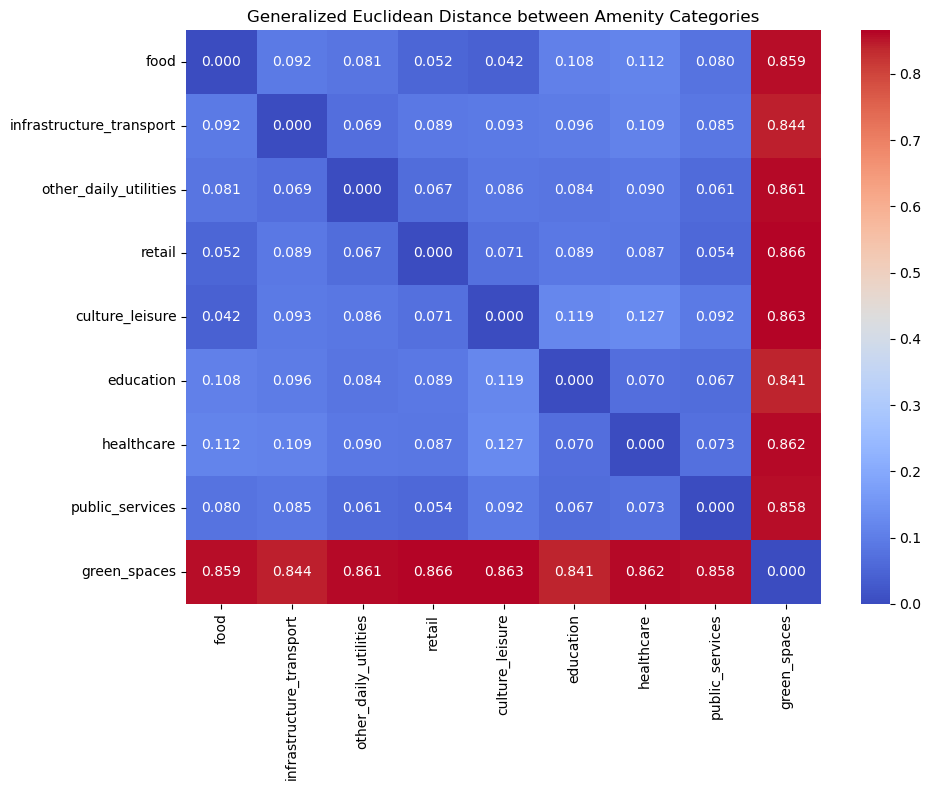

In [149]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_ge, annot=True, fmt=".3f", cmap="coolwarm")  # or "viridis", "coolwarm"
plt.title("Generalized Euclidean Distance between Amenity Categories")
plt.tight_layout()
plt.show()

Variance

In [150]:
# Precompute resistance once
resistance_matrix = _resistance(G_largest)

In [151]:
# Loop over vectors v
variances = {}
for category, v_dict in category_dicts_largest.items():
    var = variance(v_dict, G_largest, shortest_path_lengths=resistance_matrix, kernel="resistance")
    variances[category] = var

df_var = pd.DataFrame.from_dict(variances, orient="index", columns=["variance"])
print(df_var)

                          variance
food                      0.393342
infrastructure_transport  0.445230
other_daily_utilities     0.450677
retail                    0.381329
culture_leisure           0.368888
education                 0.390225
healthcare                0.539664
public_services           0.433772
green_spaces              0.000000


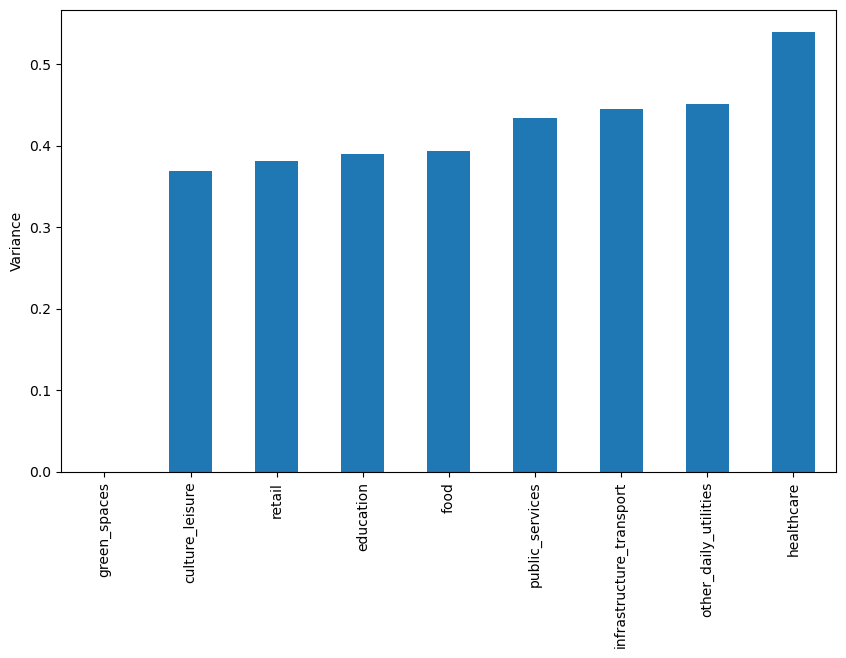

In [152]:
df_var.sort_values("variance").plot(kind="bar", legend=False, figsize=(10,6))
plt.ylabel("Variance")
plt.show()